In [55]:
#importar bibliotecas
#!pip install -U scikit-learn
import pandas as pd
import numpy as np
from sklearn import preprocessing 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression , Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import  GridSearchCV , train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler ,PolynomialFeatures,normalize
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#from sklearn.preprocessing import scale
#
#from sklearn.feature_selection import SelectKBest
#from sklearn.naive_bayes import GaussianNB
#

#from pandas.plotting import autocorrelation_plot
#from pandas.plotting import scatter_matrix
#%matplotlib inline

In [56]:
df = pd.read_csv("dados/transformado.csv", sep=",")

In [57]:
#transformando as dados categoricos como Formação, Mandante, Visitante em dados numericos
dt = pd.concat([df['formacao_mandante'],df['formacao_visitante']])

le = preprocessing.LabelEncoder()
le.fit(dt)
df['formacao_mandante'] = le.transform(df["formacao_mandante"])
df['formacao_visitante'] = le.transform(df["formacao_visitante"])



le.fit(df['vencedor'])
df['mandante'] = le.transform(df["mandante"])
df['visitante'] = le.transform(df["visitante"])

#retirando a coluna vencedor que é do tipo categorica e vamos utilizar a columa resultado, numerica.
df.drop(columns=['vencedor','rodada','total_gols'],inplace=True)
df.tail()


,partida_id,mandante,visitante,formacao_mandante,formacao_visitante,mandante_placar,visitante_placar,chutes_mandante,chutes_no_alvo_mandante,posse_de_bola_mandante,...,posse_de_bola_visitante,passes_visitante,precisao_passes_visitante,faltas_visitante,cartao_amarelo_visitante,cartao_vermelho_visitante,impedimentos_visitante,escanteios_visitante,temporada,resultado
1871,8021,15,13,9,9,2,1,17,8,0.57,...,0.43,389,0.82,8,3,1,2,1,2022,1
1872,8022,8,17,11,11,0,1,13,4,0.41,...,0.59,463,0.82,15,2,0,0,9,2022,2
1873,8023,12,4,9,11,0,1,17,4,0.59,...,0.41,351,0.82,19,6,0,0,4,2022,2
1874,8024,21,23,11,11,3,0,15,8,0.48,...,0.52,306,0.82,17,3,0,2,5,2022,1
1875,8025,19,26,11,7,0,4,6,2,0.35,...,0.65,591,0.90,14,1,0,0,4,2022,2


In [58]:
#criando dataset auxiliar
df_aux = pd.DataFrame(df[(df['temporada']==2022)])

# Eliminando os dados de df_aux do df_model
df_model = df.drop(index = df_aux.index)

#arrumando index de df_aux
df_aux.reset_index(inplace = True)
df_aux.drop('index', axis = 1, inplace = True)

print("-----------------------------------")
print("* SHAPE DOS MODELOS")
print ("O dataset DF_MODEL será utilizado para TESTE, ele contêm {} Linhas  e  {} Colunas : ".format( df_model.shape[0] , df_model.shape[1]))
print ("O dataset DF_AUX será utilizado para VALIDAÇÃO do TESTE E TREINO, ele contem {} Linhas  e  {} Colunas : ".format( df_aux.shape[0] , df_aux.shape[1]))
print(" ")
print("-----------------------------------")
print("* TEMPORADAS DO MODELO ")
print("Temporada Modelo", df_model.temporada.unique(), " Qtd linhas x colunas", df_model.shape)
print("Temporada Auxiliar" , df_aux.temporada.unique() , " Qtd linhas x colunas",df_aux.shape)

-----------------------------------
* SHAPE DOS MODELOS
O dataset DF_MODEL será utilizado para TESTE, ele contêm 1496 Linhas  e  30 Colunas : 
O dataset DF_AUX será utilizado para VALIDAÇÃO do TESTE E TREINO, ele contem 380 Linhas  e  30 Colunas : 
 
-----------------------------------
* TEMPORADAS DO MODELO 
Temporada Modelo [2018 2019 2020 2021]  Qtd linhas x colunas (1496, 30)
Temporada Auxiliar [2022]  Qtd linhas x colunas (380, 30)


In [59]:
#separar features e label
label_model = df[(df['temporada'] <= 2021)]['resultado']
label_aux = df[(df['temporada'] == 2022)]['resultado']


features_model = df[(df['temporada'] <= 2021)]
features_aux = df[(df['temporada'] == 2022)]

features_model = features_model.drop(columns=['resultado'])
features_aux = features_aux.drop(columns=['resultado'])

In [60]:
#Devido as diferenças numericas entre os dados, vamos normaliza-los.
# Normalizando os dados de entrada(features)

scaler = MinMaxScaler().fit(features_model)
features_scale_model = scaler.transform(features_model)
features_scale_aux = scaler.transform(features_aux)


In [61]:
# Separando os dados de Treino e Teste, com 20% para testes, lembrando que o df_aux só será utilizando para validação do ML

SEED = 23
np.random.seed(SEED)
X_train, X_test, y_train, y_test = train_test_split(features_scale_model, label_model, test_size = 0.20, stratify = label_model )

print('O dataset de treino possui {} linhas e o de teste {} linhas.'.format(X_train.shape[0], X_test.shape[0]))

O dataset de treino possui 1196 linhas e o de teste 300 linhas.


In [62]:
#Os modelos que iremos utilizar é LogisticRegression , SVC , Decision Tree

model_logr = LogisticRegression(multi_class='multinomial',max_iter=2000)
model_svc = SVC()
model_dtc = DecisionTreeClassifier(max_depth=3)
model_rand = RandomForestClassifier(n_estimators=100)

models = [model_logr,model_svc,model_dtc,model_rand]


#Treinando os modelos e informando a Acurácia 
for model in models:
    model.fit(X_train,y_train)
    pred= model.predict(X_test)
    svc_acc = accuracy_score(y_test, pred)
    f1=f1_score(y_test,pred, average='micro')
    recal = recall_score(y_test,pred, average='micro')

    print('MODELO {} '.format(model))
    print(" ")
    print('Acurácia : {}'.format(svc_acc))
    print('F1 Score : {}'.format(f1))
    print('recall : {}'.format(recal))
    print(" ")
    print(" ")

MODELO LogisticRegression(max_iter=2000, multi_class='multinomial') 
 
Acurácia : 0.9566666666666667
F1 Score : 0.9566666666666667
recall : 0.9566666666666667
 
 
MODELO SVC() 
 
Acurácia : 0.9833333333333333
F1 Score : 0.9833333333333333
recall : 0.9833333333333333
 
 
MODELO DecisionTreeClassifier(max_depth=3) 
 
Acurácia : 0.7966666666666666
F1 Score : 0.7966666666666665
recall : 0.7966666666666666
 
 
MODELO RandomForestClassifier() 
 
Acurácia : 0.97
F1 Score : 0.97
recall : 0.97
 
 


In [63]:
#Vamos realizar a validação dos modelos acima
from sklearn.model_selection import KFold

def intervalo(results):
        mean = results.mean()
        dv = results.std()
     
        print("==========================================")
        print("Modelo: {}".format(model))
        print('Acurácia média: {:.2f}%'.format(mean*100))
        print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))
      
        print(" ")

SEED = 42
np.random.seed(SEED)

#Divide o conjunto de dados em k dobras, permitindo que cada parte do conjunto de dados seja usada para teste e treinamento em diferentes momentos.
#cv = StratifiedKFold(n_splits = 5, shuffle = True)
cv = KFold(n_splits = 5, shuffle = True)

print("******* CROSS VALIDATION - accuracy ******* ")
print(" ")
print(" ")
for model in models:
    results = cross_val_score(model, X_train,y_train, cv = cv, scoring = 'accuracy')
    intervalo(results)
    
    
    

******* CROSS VALIDATION - accuracy ******* 
 
 
Modelo: LogisticRegression(max_iter=2000, multi_class='multinomial')
Acurácia média: 93.48%
Intervalo de acurácia: [91.22% ~ 95.74%]
 
Modelo: SVC()
Acurácia média: 95.99%
Intervalo de acurácia: [93.58% ~ 98.39%]
 
Modelo: DecisionTreeClassifier(max_depth=3)
Acurácia média: 83.87%
Intervalo de acurácia: [75.46% ~ 92.28%]
 
Modelo: RandomForestClassifier()
Acurácia média: 96.57%
Intervalo de acurácia: [94.24% ~ 98.91%]
 


In [64]:
#Vamos realizar a validação dos modelos acima
from sklearn.model_selection import KFold

def intervalo_prec(results):
    mean = results.mean()
    dv = results.std()
    print("==========================================")
    print("Modelo: {}".format(model))
    print('Precisão média: {:.2f}%'.format(mean*100))
    print('Intervalo de Precisão: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))
    print(" ")
    
    

SEED = 42
np.random.seed(SEED)
#cv = StratifiedKFold(n_splits = 5, shuffle = True)

#Divide o conjunto de dados em k dobras, permitindo que cada parte do conjunto de dados seja usada para teste e treinamento em diferentes momentos.
#cv = StratifiedKFold(n_splits = 5, shuffle = True)
cv = KFold(n_splits = 5, shuffle = True)

print("******* CROSS VALIDATION - precision_macro ******* ")
print(" ")
print(" ")
for model in models:
    results = cross_val_score(model, X_train,y_train, cv = cv, scoring = 'precision_macro')
    intervalo_prec(results)

******* CROSS VALIDATION - precision_macro ******* 
 
 
Modelo: LogisticRegression(max_iter=2000, multi_class='multinomial')
Precisão média: 93.17%
Intervalo de Precisão: [89.40% ~ 96.95%]
 
Modelo: SVC()
Precisão média: 95.70%
Intervalo de Precisão: [92.58% ~ 98.83%]
 
Modelo: DecisionTreeClassifier(max_depth=3)
Precisão média: 86.04%
Intervalo de Precisão: [78.59% ~ 93.49%]
 
Modelo: RandomForestClassifier()
Precisão média: 96.61%
Intervalo de Precisão: [94.49% ~ 98.72%]
 


In [65]:
#Vamos realizar a validação dos modelos acima
from sklearn.model_selection import KFold

def intervalo_prec(results):
    mean = results.mean()
    dv = results.std()
    print("==========================================")
    print("Modelo: {}".format(model))
    print('Recall média: {:.2f}%'.format(mean*100))
    print('Intervalo de Recall: [{:.2f}% ~ {:.2f}%]'.format((mean - 2*dv)*100, (mean + 2*dv)*100))
    print(" ")
    
    

SEED = 42
np.random.seed(SEED)
#cv = StratifiedKFold(n_splits = 5, shuffle = True)

#Divide o conjunto de dados em k dobras, permitindo que cada parte do conjunto de dados seja usada para teste e treinamento em diferentes momentos.
#cv = StratifiedKFold(n_splits = 5, shuffle = True)
cv = KFold(n_splits = 5, shuffle = True)

print("******* CROSS VALIDATION - recall_macro ******* ")
print(" ")
print(" ")
for model in models:
    results = cross_val_score(model, X_train,y_train, cv = cv, scoring = 'recall_macro')
    intervalo_prec(results)

******* CROSS VALIDATION - recall_macro ******* 
 
 
Modelo: LogisticRegression(max_iter=2000, multi_class='multinomial')
Recall média: 91.79%
Intervalo de Recall: [88.90% ~ 94.67%]
 
Modelo: SVC()
Recall média: 94.77%
Intervalo de Recall: [91.60% ~ 97.94%]
 
Modelo: DecisionTreeClassifier(max_depth=3)
Recall média: 78.28%
Intervalo de Recall: [65.33% ~ 91.23%]
 
Modelo: RandomForestClassifier()
Recall média: 95.82%
Intervalo de Recall: [93.02% ~ 98.62%]
 


In [66]:
#Testando modelo

SEED = 23
np.random.seed(SEED)

X_pred = X_test
y_pred = y_test


pred=model_rand.predict(X_pred)

svc_acc = accuracy_score(y_pred, pred)
f1=f1_score(y_pred,pred, average='micro')
recal = recall_score(y_pred,pred, average='micro')
print("======= TESTE =======")
print('MODELO {} '.format(model_rand))
print(" ")
print('Acurácia : {}'.format(svc_acc))
print('F1 Score : {}'.format(f1))
print('recall : {}'.format(recal))
print(" ")
print(" ")

======= TESTE =======
MODELO RandomForestClassifier() 
 
Acurácia : 0.97
F1 Score : 0.97
recall : 0.97
 
 


In [67]:
#Validação com dados nunca vistos

SEED = 23
np.random.seed(SEED)

X_pred = features_scale_aux
y_pred = label_aux


pred_final=model_rand.predict(X_pred)

svc_acc = accuracy_score(y_pred, pred_final)
f1=f1_score(y_pred,pred_final, average='micro')
recal = recall_score(y_pred,pred_final, average='micro')
print("======= VALIDAÇÃO =======")
print(" ")
print('MODELO {} '.format(model_rand))
print(" ")
print('Acurácia : {}'.format(svc_acc))
print('F1 Score : {}'.format(f1))
print('recall : {}'.format(recal))
print(" ")
print(" ")

======= VALIDAÇÃO =======
 
MODELO RandomForestClassifier() 
 
Acurácia : 0.9342105263157895
F1 Score : 0.9342105263157895
recall : 0.9342105263157895
 
 


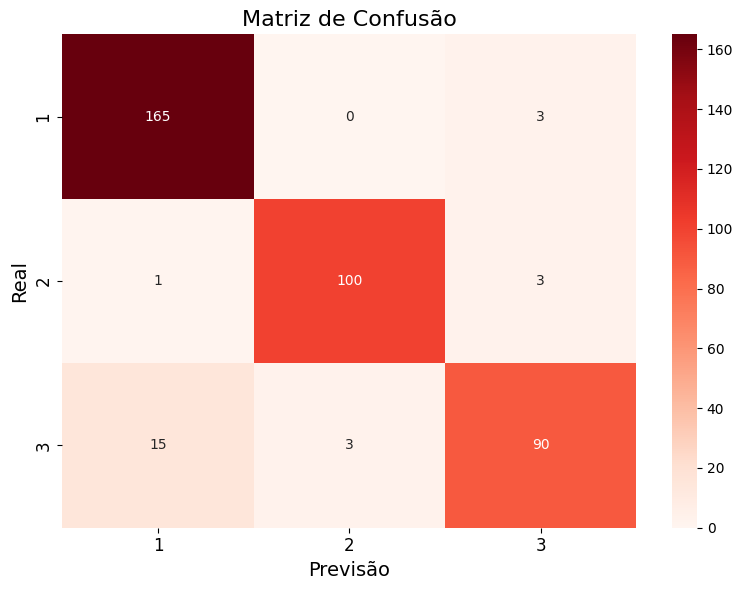

In [68]:
cf_matrix=pd.crosstab(y_pred, pred_final, rownames=['real'] , colnames=['previsao'])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Reds', cbar=True, ax=ax)
ax.set_title('Matriz de Confusão', fontsize=16)
ax.set_xlabel('Previsão', fontsize=14)
ax.set_ylabel('Real', fontsize=14)
ax.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

In [69]:
df=pd.DataFrame({'real': y_pred, 'previsao':pred_final, 'partida_id':features_aux['partida_id']})

print(df)


      real  previsao  partida_id
1496     3         3        7646
1497     3         3        7647
1498     2         2        7648
1499     1         1        7649
1500     2         2        7650
...    ...       ...         ...
1871     1         1        8021
1872     2         2        8022
1873     2         2        8023
1874     1         1        8024
1875     2         2        8025

[380 rows x 3 columns]
